In [754]:
import numpy as np

from itertools import product, combinations

import warnings

import matplotlib.pyplot as plt
import networkx as nx
import plotly.graph_objs as go
from plotly.subplots import make_subplots

import random

from qiskit_aer import AerSimulator

from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister, transpile
from qiskit.quantum_info import Statevector, partial_trace

from initialization.state_preparation.gates import WeightedUnaryEncoding
from initialization.calculate_w import get_optimal_w, calculate_w
from initialization.construct_A import construct_A_matrix

from dicke_state_preparation.gates import UnkStatePreparation

from decoding.gates import GJEGate

from utils import *

warnings.filterwarnings("ignore")

Found a graph after 4 iterations!
Max-XORSAT Constraint Matrix (B):
[[1 0 0 0 0 0 0 1]
 [1 1 0 0 0 0 0 0]
 [0 0 1 1 0 0 0 0]
 [0 0 1 0 0 0 0 1]
 [0 0 1 0 1 0 0 0]
 [0 0 0 0 1 1 0 0]
 [0 0 0 0 0 1 0 1]
 [0 0 0 0 0 0 1 1]]

Right-Hand Side Vector (v):
[1 1 1 1 1 1 1 1]

Maximum number of XOR constraints satisfied: 8
2 assignments:
{0: 0, 1: 1, 2: 0, 3: 1, 4: 1, 5: 0, 6: 0, 7: 1}
{0: 1, 1: 0, 2: 1, 3: 0, 4: 0, 5: 1, 6: 1, 7: 0}


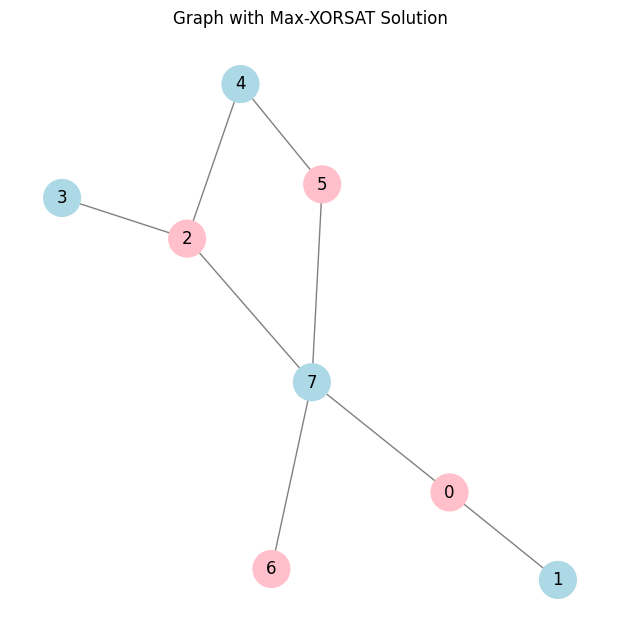

In [791]:
# Specify parameters for the graph and search:
num_nodes = 8              # Number of nodes (variables)
num_edges = 8               # Number of XOR constraints (edges)
target_max_solutions = 2   # Desired number of assignments achieving max satisfied constraints
max_iter = 1000            # Maximum iterations for search
seed = 1000                   # Seed for reproducibility

show_sv = False
if num_nodes * num_edges < 50:
    show_sv = True

# Search for a graph with the specified number of max solutions.
result = find_graph_with_target_max_solutions(num_nodes, num_edges, target_max_solutions, seed, max_iter)
G, best_assignments, max_satisfied, iterations = result

if G is not None:
    print(f"Found a graph after {iterations} iterations!")
    B, v = get_max_xorsat_matrix(G, v=None) # [0, 1, 0, 1, 1])
    # B = np.array([[1, 1, 0, 0, 0, 0,],
    #             [1, 0, 0, 0, 1, 0,],
    #             [0, 1, 1, 0, 0, 0,],
    #             [0, 0, 1, 1, 0, 0,],
    #             [0, 0, 0, 1, 0, 1,],
    #             [0, 0, 0, 0, 1, 1,]])
    print("Max-XORSAT Constraint Matrix (B):")
    print(B)
    print("\nRight-Hand Side Vector (v):")
    print(v)
    print(f"\nMaximum number of XOR constraints satisfied: {max_satisfied}")
    print(f"{len(best_assignments)} assignments:")
    for assignment in best_assignments:
        print(assignment)
    
    # Draw the graph using the first maximum assignment
    draw_graph(G, best_assignments[0])
else:
    print(f"No graph found in {max_iter} iterations that has exactly {target_max_solutions} maximum solutions.")


In [792]:
brute_force_results = brute_force_max(B, v, first_part="")
plot_results_union_plotly(
    brute_force_results, 
    {}, 
    plot_name="Objective values lanscape", 
    spline_smoothing=1.3
)

In [793]:
n = len(B[0])

m, p, r, ell = len(B), 2, 1, 2

w, _ = get_optimal_w(m, n, ell, p, r)
# A, _ = construct_A_matrix(m, ell, p, r)
# w, _ = calculate_w(A)
print("Optimal W_k value: ", w.tolist())

Optimal W_k value:  [0.0, 0.7071067811865476, 0.7071067811865475, 0.0]


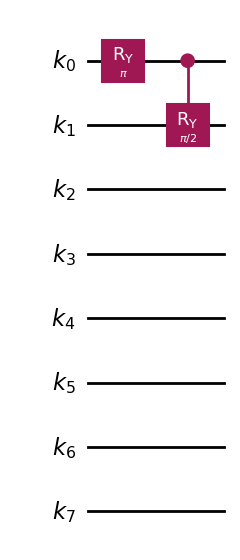

In [794]:
init_qregs = QuantumRegister(m, name='k')
initialize_circuit = QuantumCircuit(init_qregs)
WUE_Gate = WeightedUnaryEncoding(m, w)
initialize_circuit.append(WUE_Gate, range(m))
display(initialize_circuit.decompose().draw('mpl'))

In [795]:
Statevector(initialize_circuit).draw('latex') if show_sv else None

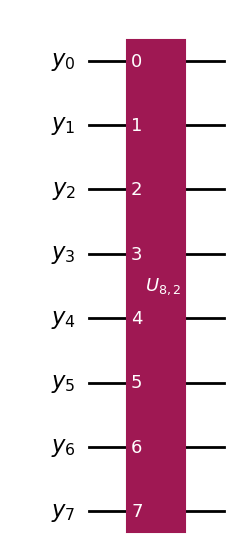

In [796]:
dicke_qregs = QuantumRegister(m, name='y') 

dicke_circuit = QuantumCircuit(dicke_qregs)
max_errors = int(np.nonzero(w)[0][-1]) if np.any(w) else 0
dicke_circuit.append(UnkStatePreparation(m, max_errors).to_gate(), range(m))
dicke_circuit.draw('mpl')

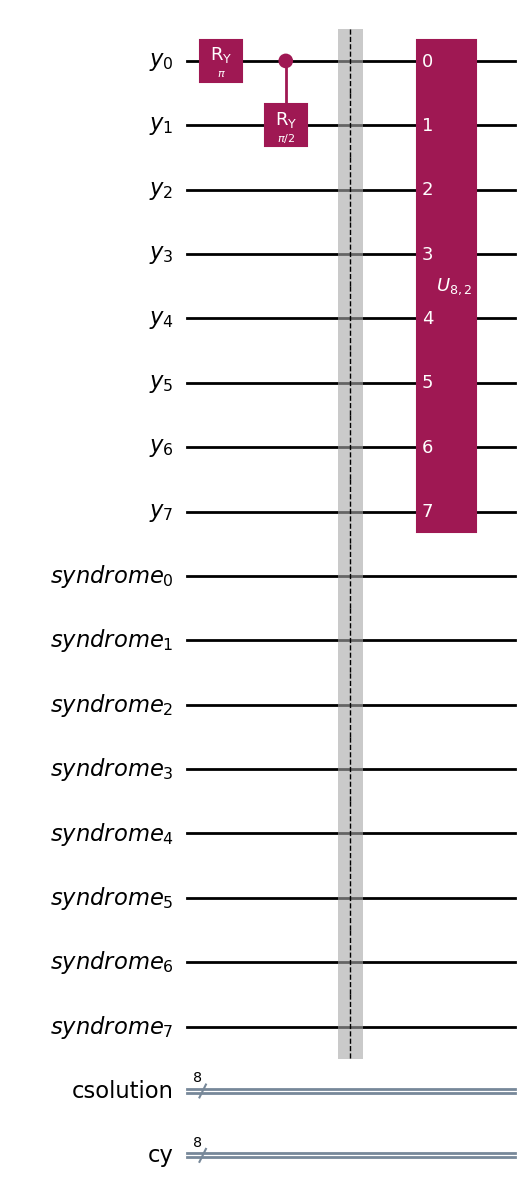

In [797]:
dicke_cregs = ClassicalRegister(dicke_qregs.size, name='cy')
syndrome_qregs = QuantumRegister(n, name='syndrome')
syndrome_cregs = ClassicalRegister(syndrome_qregs.size, name='csolution')

dqi_circuit = QuantumCircuit(dicke_qregs, syndrome_qregs, syndrome_cregs, dicke_cregs)
dqi_circuit.compose(initialize_circuit, inplace=True)
dqi_circuit.barrier()
dqi_circuit.compose(dicke_circuit, inplace=True)
dqi_circuit.decompose().draw('mpl')

In [798]:
Statevector(dqi_circuit).draw('latex') if show_sv else None

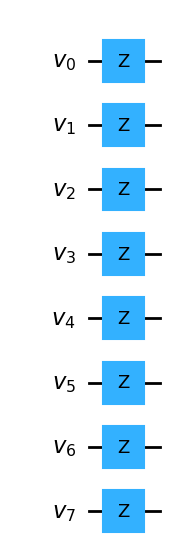

In [799]:
v_phase_qregs = QuantumRegister(m, name='v')
v_phase_flip_circuit = QuantumCircuit(v_phase_qregs)
for i in range(len(v)):
    if v[i] == 1:
        v_phase_flip_circuit.z(i)
v_phase_flip_circuit.draw('mpl')

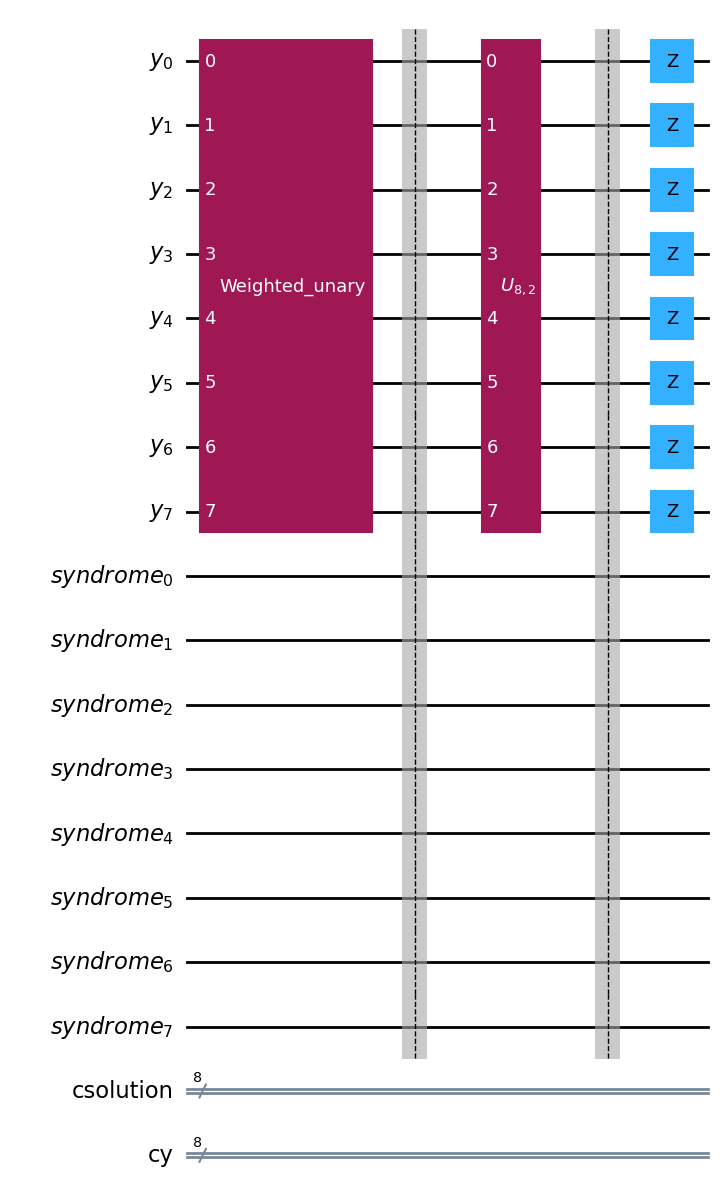

In [800]:
dqi_circuit.barrier()
dqi_circuit.compose(v_phase_flip_circuit, qubits=range(m), inplace=True)
dqi_circuit.draw('mpl')

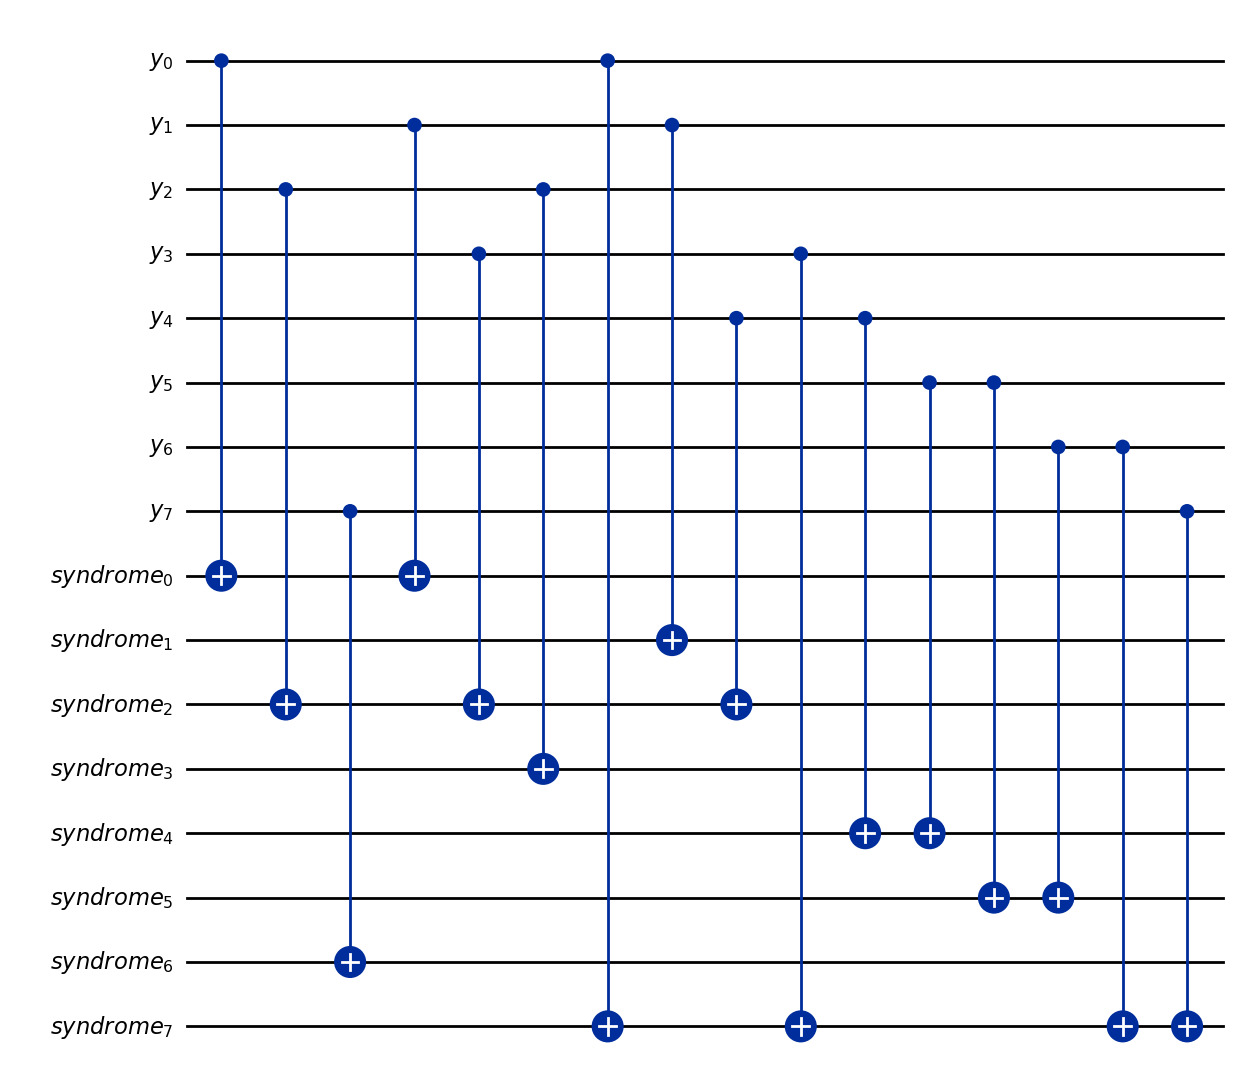

In [801]:
B_circuit = QuantumCircuit(dicke_qregs, syndrome_qregs)
for i in range(n):
    for j in range(m):
        if B.T[i][j] == 1:
            B_circuit.cx(j, m+i)
            
B_circuit.draw('mpl')

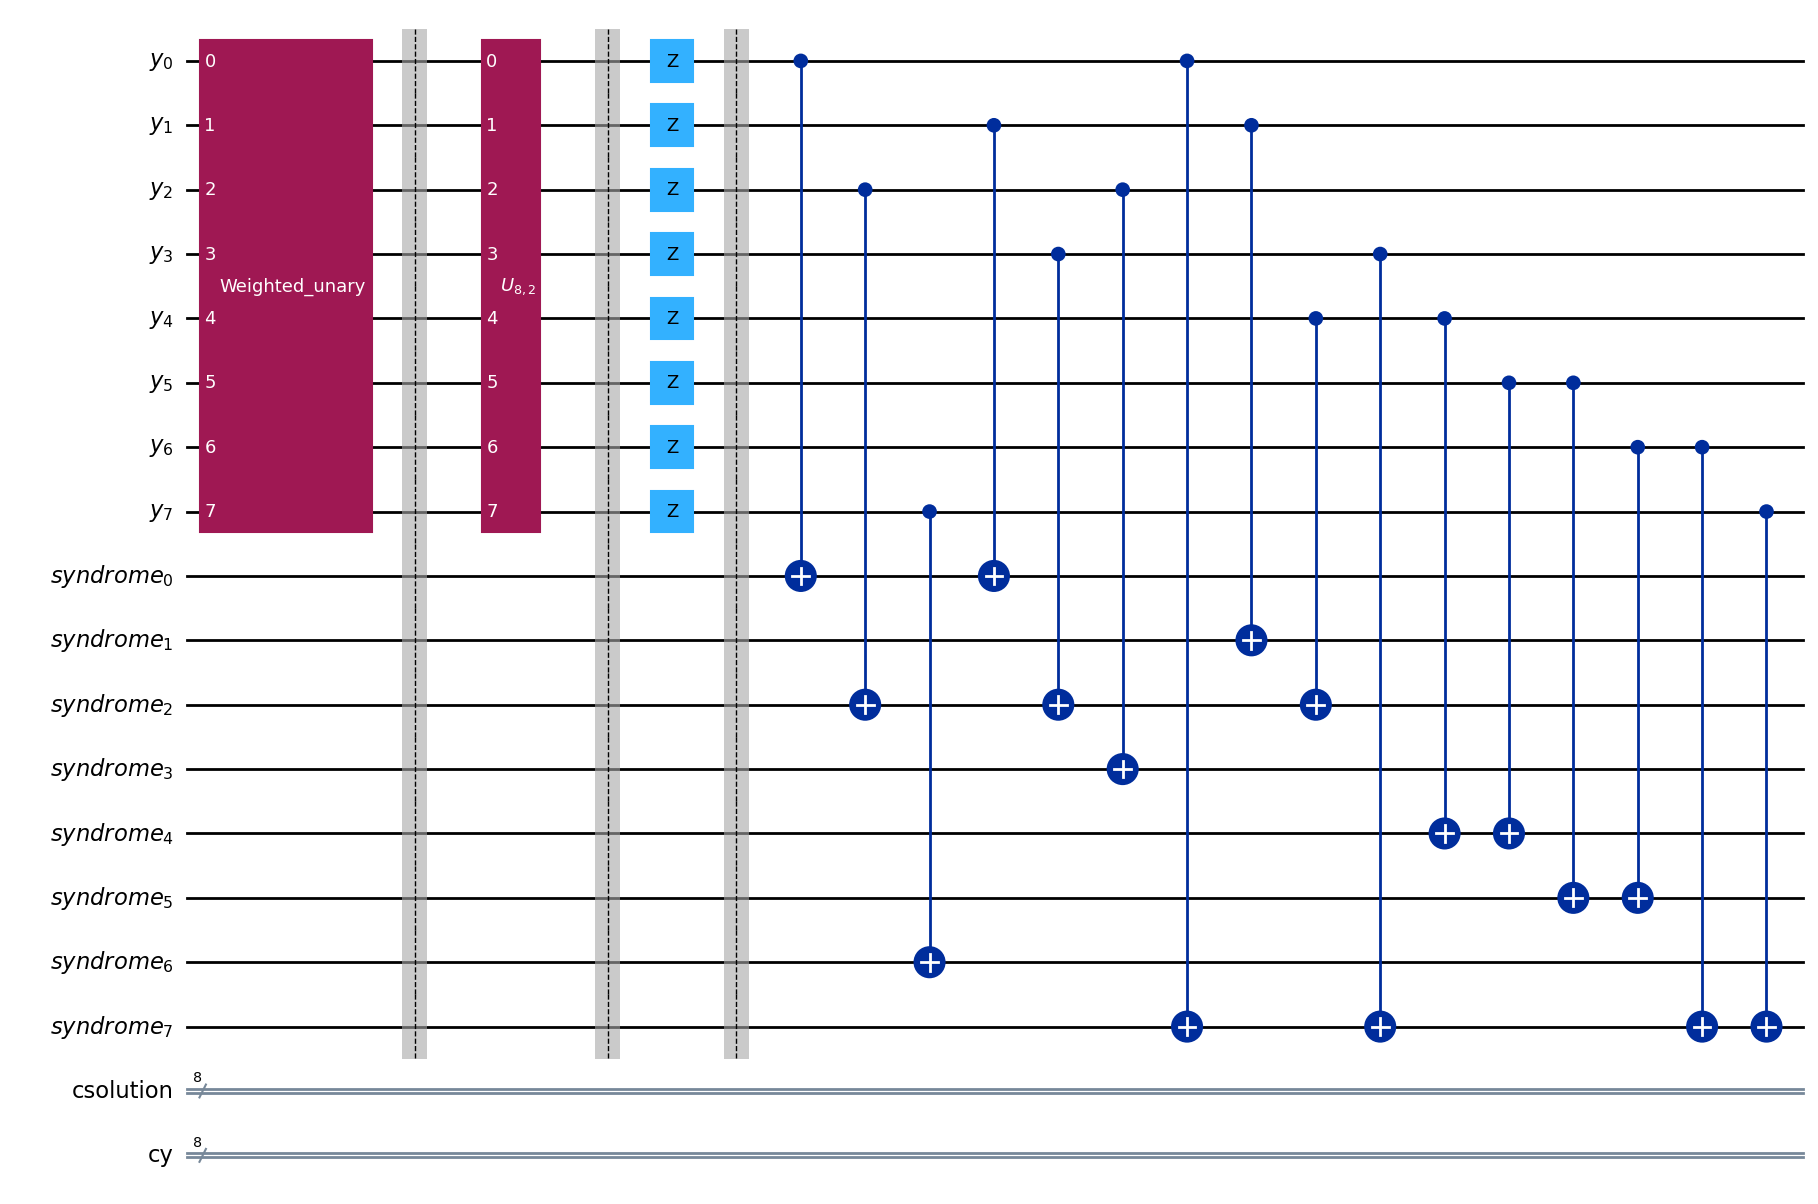

In [802]:
dqi_circuit.barrier()
dqi_circuit.compose(B_circuit, qubits=list(range(m+n)), inplace=True)
dqi_circuit.draw('mpl')

In [803]:
reduced_density_matrix = partial_trace(Statevector(dqi_circuit), range(m))

Statevector(np.diagonal(reduced_density_matrix)).draw('latex') if show_sv else None


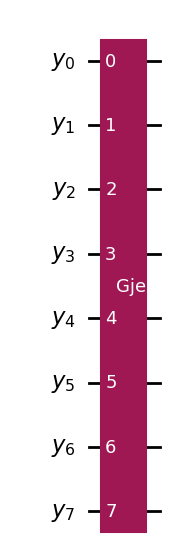

In [804]:
if n>m:
    decoding_circuit = QuantumCircuit(syndrome_qregs, name="GJE")
    GJE_gate = GJEGate(B.T)
    decoding_circuit.append(GJE_gate, range(n))
else:
    decoding_circuit = QuantumCircuit(dicke_qregs, name="GJE")
    GJE_gate = GJEGate(B.T)
    decoding_circuit.append(GJE_gate, range(n))

display(decoding_circuit.draw('mpl'))

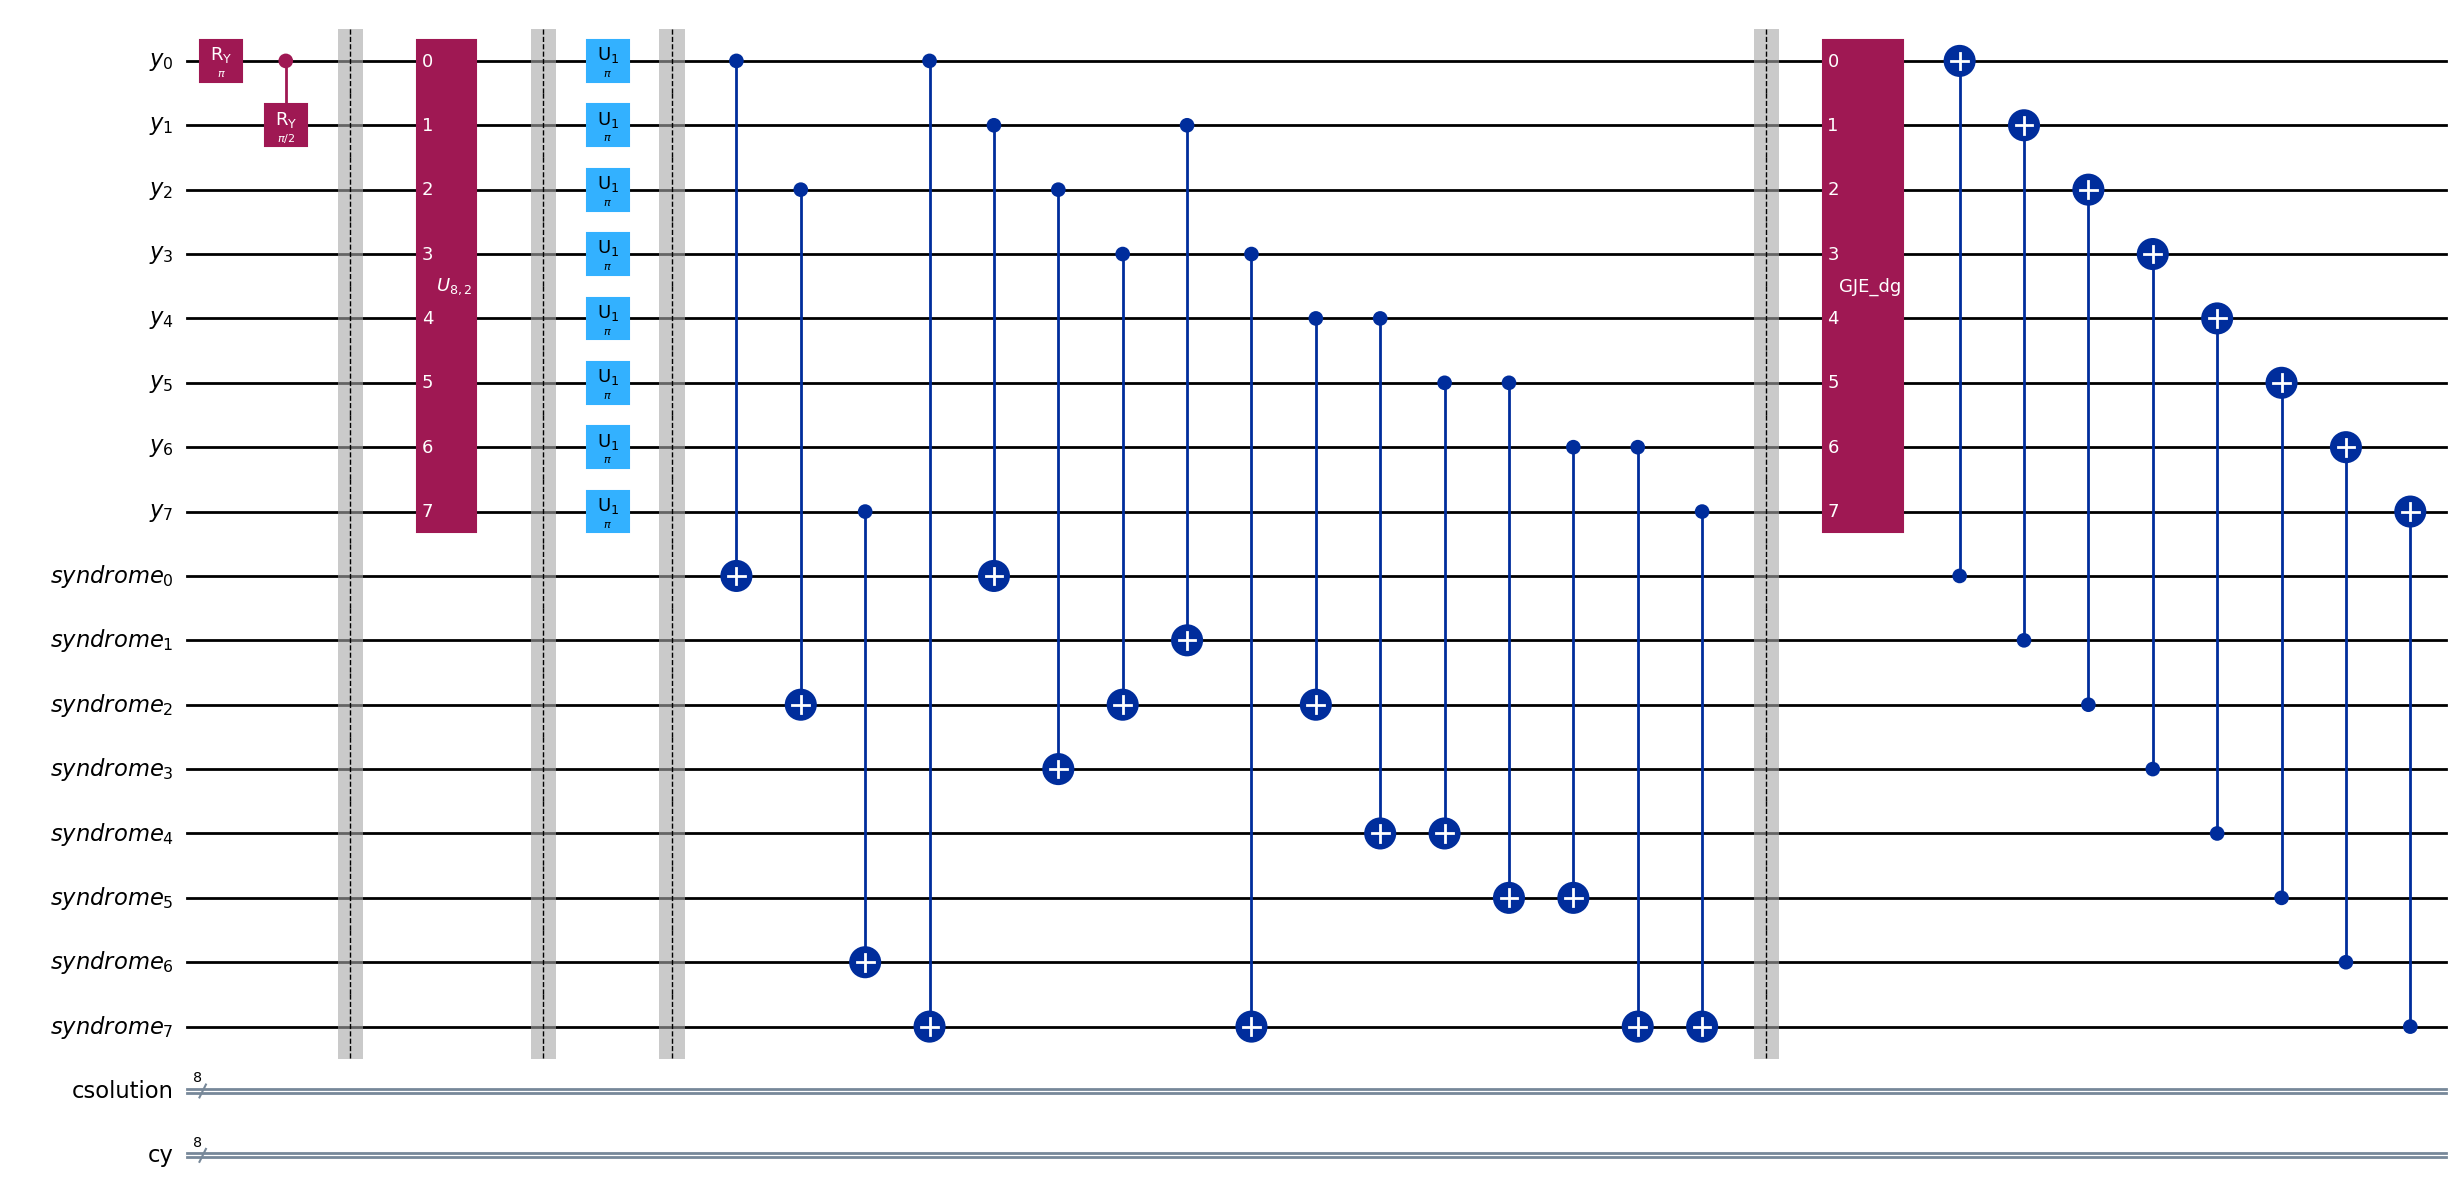

In [805]:
dqi_circuit_wo_decoder = dqi_circuit.copy()
dqi_circuit.barrier()

if n>m:
    dqi_circuit.append(decoding_circuit, range(m, m+n))
    for i in range(m):
        dqi_circuit.cx(syndrome_qregs[i], dicke_qregs[i])
    dqi_circuit.append(decoding_circuit.inverse(), range(m, m+n))
else:
    dqi_circuit.append(decoding_circuit.inverse(), range(m))
    for i in range(n):
        dqi_circuit.cx(syndrome_qregs[i], dicke_qregs[i])

display(dqi_circuit.decompose().draw('mpl', fold=-1))

In [806]:
reduced_density_matrix = partial_trace(Statevector(dqi_circuit), range(m, m+n))

Statevector(np.diagonal(reduced_density_matrix)).draw('latex') if show_sv else None


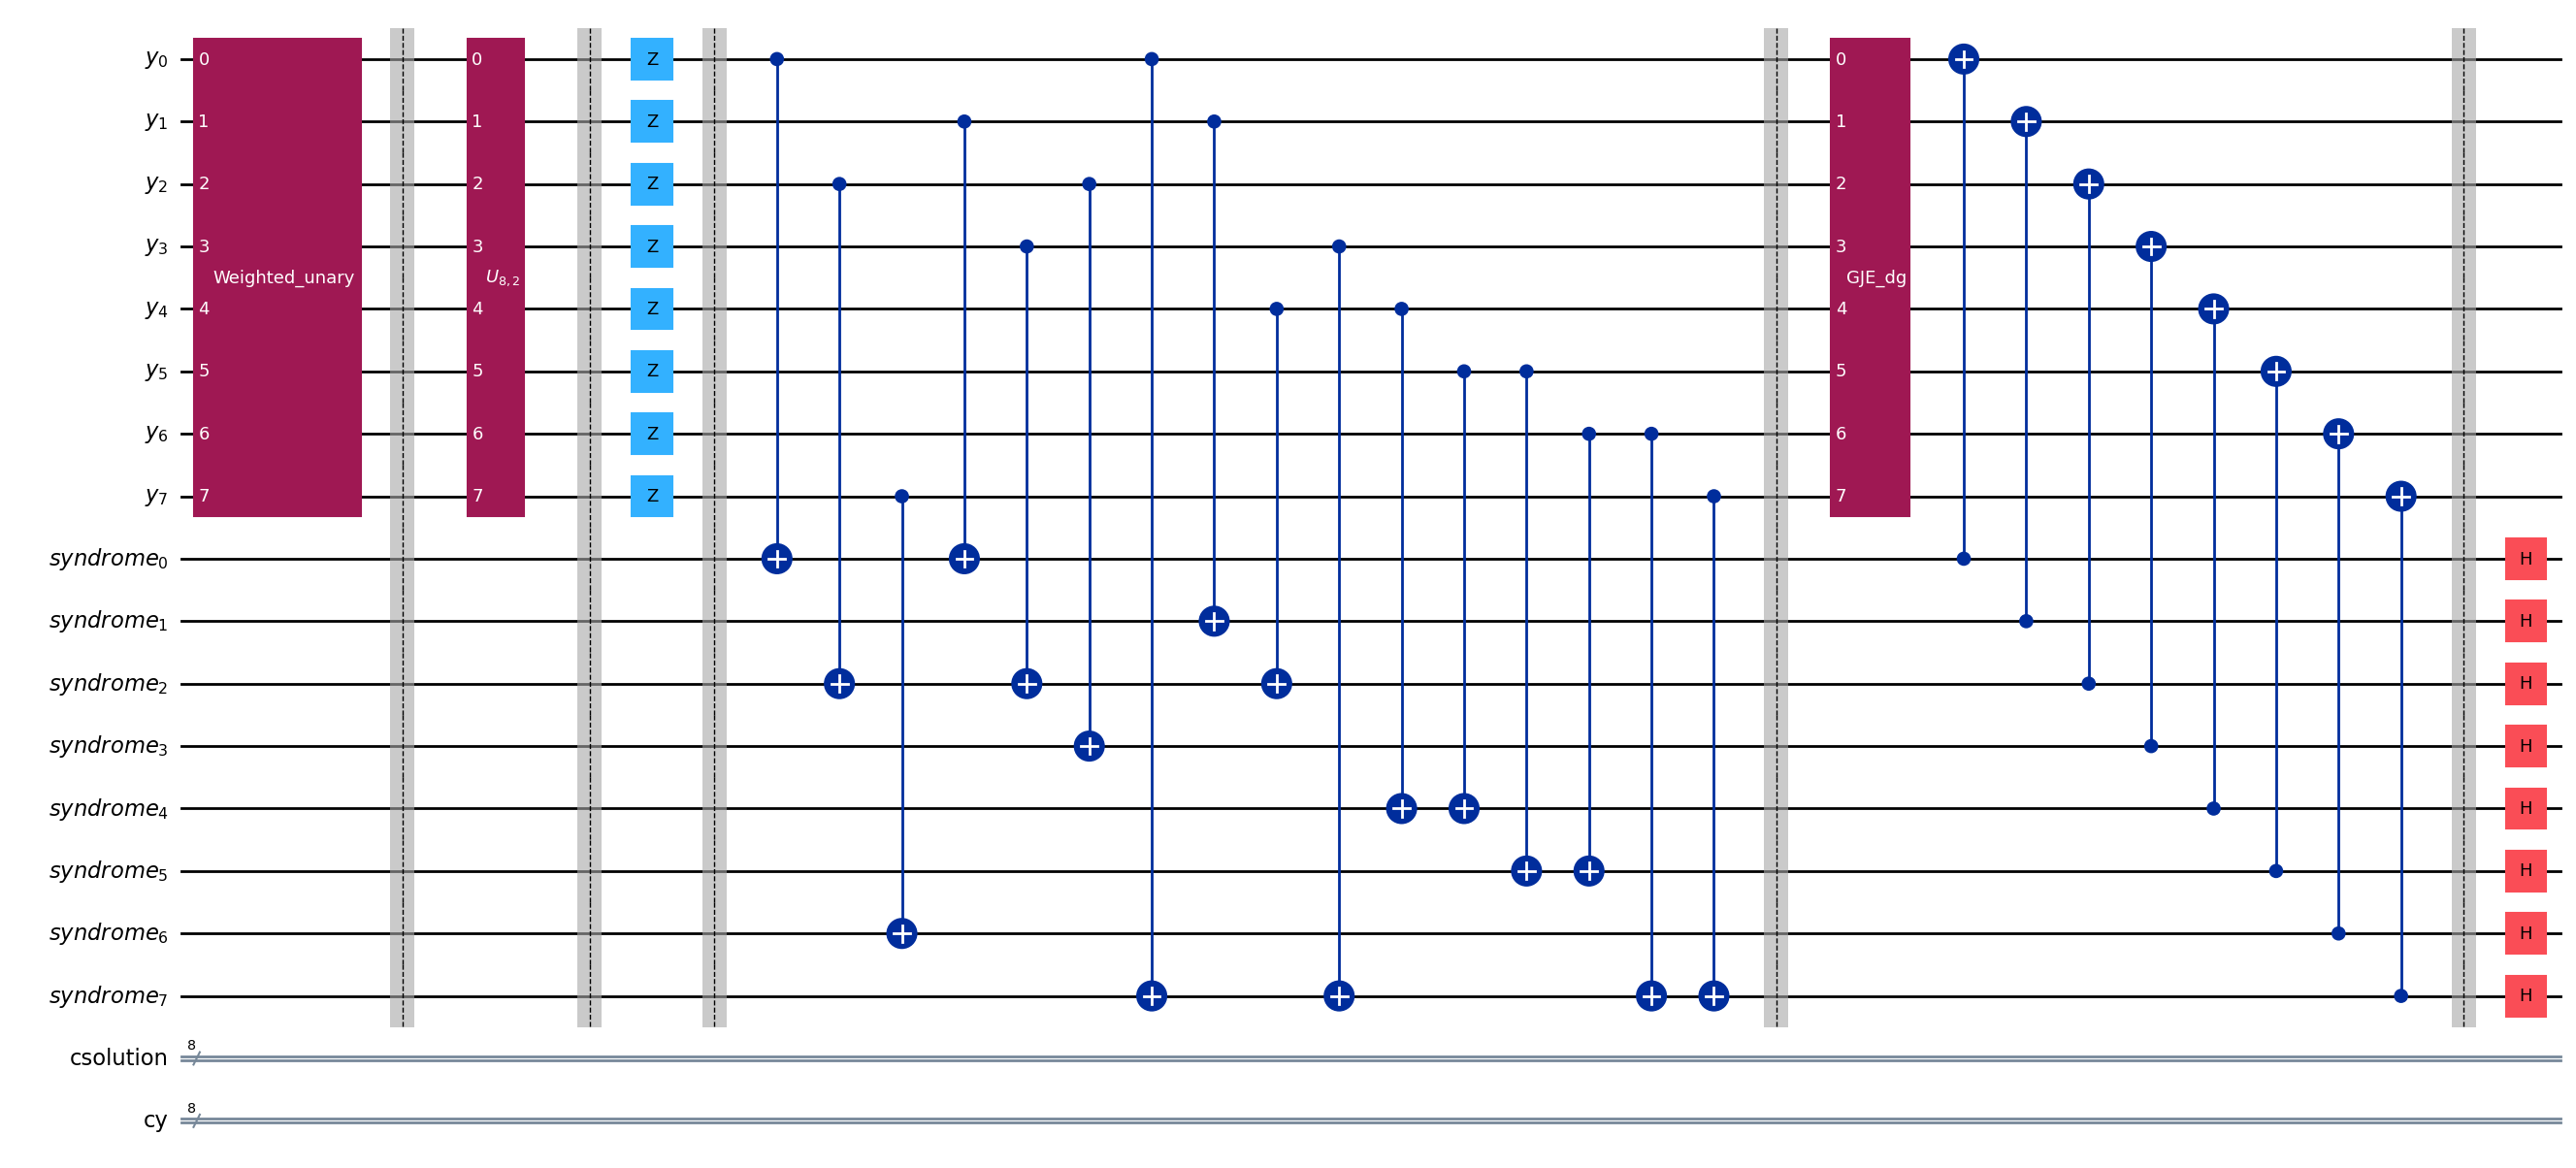

In [807]:
dqi_circuit.barrier()
for i in range(n):
    dqi_circuit.h(m+i)
display(dqi_circuit.draw('mpl', fold=-1))

In [808]:
reduced_density_matrix = partial_trace(Statevector(dqi_circuit), range(m, m+n))

Statevector(np.diagonal(reduced_density_matrix)).draw('latex') if show_sv else None


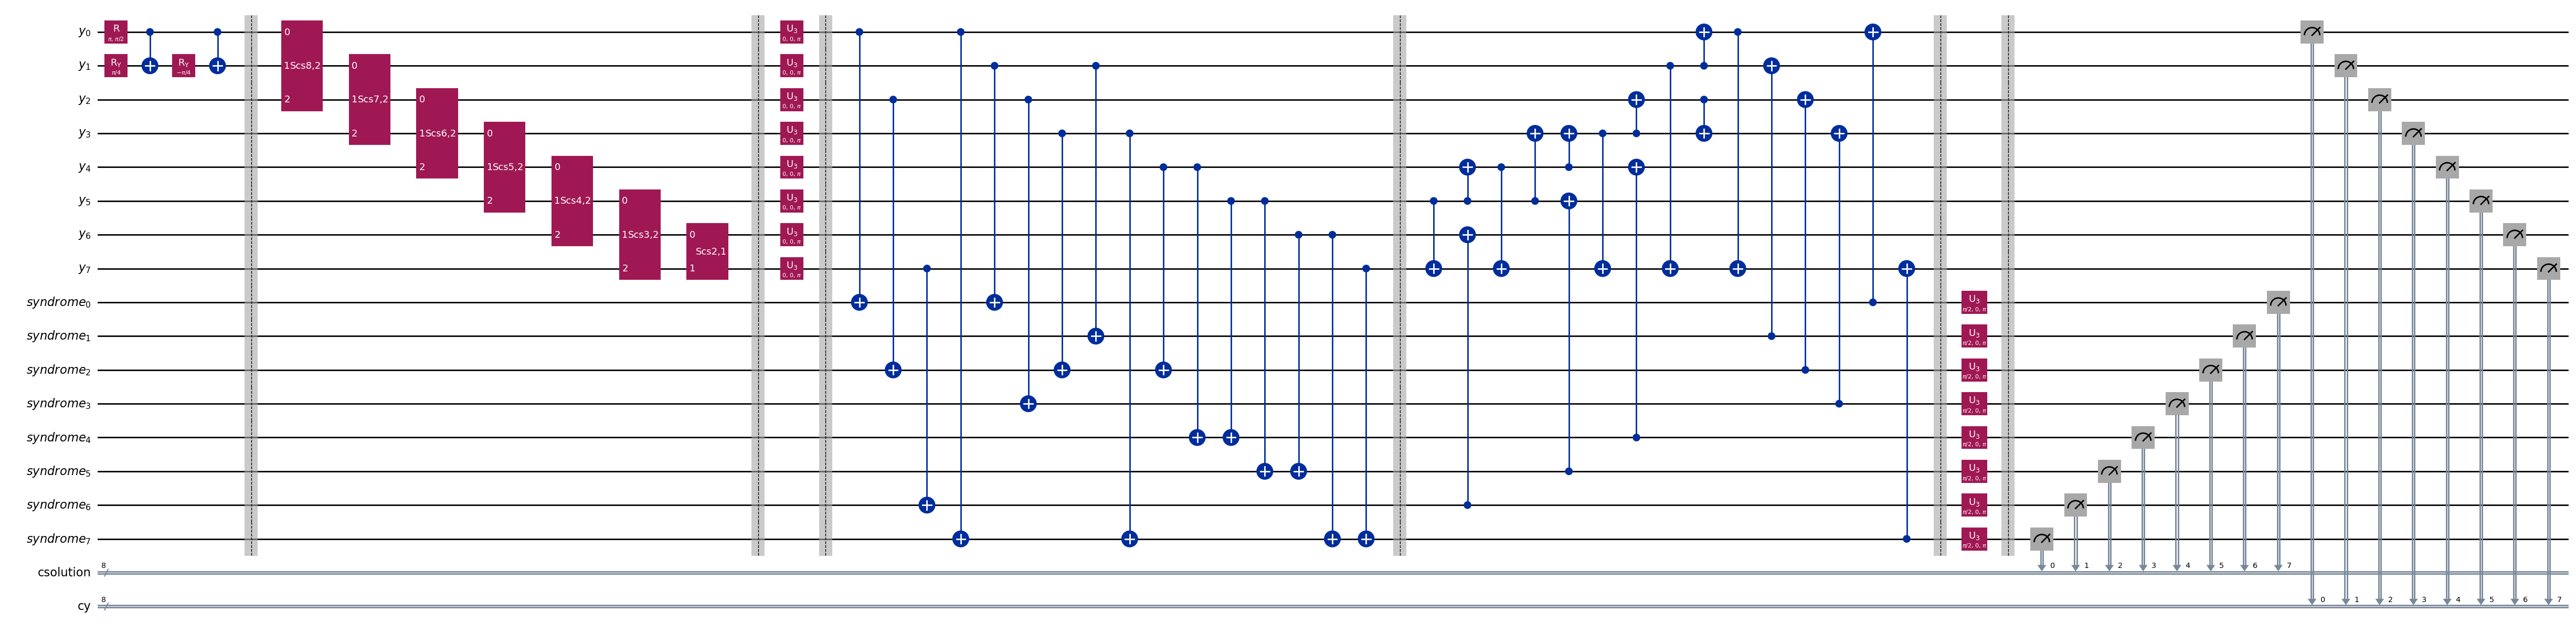

In [809]:
dqi_circuit.barrier()
dqi_circuit.measure(dicke_qregs, dicke_cregs)
dqi_circuit.measure(syndrome_qregs, syndrome_cregs[::-1])
dqi_circuit.decompose().decompose().draw('mpl', fold=-1)

In [810]:
simulator = AerSimulator()
transpiled_circuit = transpile(dqi_circuit, backend=simulator)
result = simulator.run(transpiled_circuit, shots=100000).result()
counts = result.get_counts(dqi_circuit)
{k: v for k, v in sorted(counts.items(), key=lambda item: item[1], reverse=True)}


{'00000000 01011011': 4854,
 '00000000 01011001': 4736,
 '00000000 10100100': 4700,
 '00000000 10100110': 4667,
 '00000000 01010101': 1167,
 '00000000 01001011': 1145,
 '00000000 01010111': 1143,
 '00000000 10011011': 1124,
 '00000000 10101000': 1124,
 '00000000 01001001': 1106,
 '00000000 11100100': 1101,
 '00000000 10100000': 1100,
 '00000000 10100010': 1099,
 '00000000 01011111': 1098,
 '00000000 01100101': 1094,
 '00000000 10110110': 1094,
 '00000000 10011000': 1090,
 '00000000 00011001': 1088,
 '00000000 11100110': 1084,
 '00000000 00011011': 1081,
 '00000000 01100110': 1080,
 '00000000 10011010': 1078,
 '00000000 10101010': 1077,
 '00000000 01100111': 1074,
 '00000000 10110100': 1070,
 '00000000 01100100': 1068,
 '00000000 10011001': 1060,
 '00000000 01011101': 1048,
 '01000000 01011001': 465,
 '11100000 10100110': 453,
 '01000000 10100100': 443,
 '01000000 01011011': 425,
 '11100000 10100100': 413,
 '11100000 01011011': 407,
 '11100000 01011001': 398,
 '01000000 10100110': 378,


In [811]:
brute_force_results = brute_force_max(B, v, first_part="0"*m)
external_data = counts  # A dict of {binary_label: count}
plot_results_union_plotly(
    brute_force_results, 
    external_data, 
    plot_name="Comparison of DQI result and True Objective Values", 
    spline_smoothing=0.8
)


In [812]:
external_data = {k: v  for k, v in sorted(counts.items(), key=lambda item: item[1], reverse=True) if sum([int(v) for v in k.split(" ")[0]]) == 0}
plot_results_union_plotly(
    brute_force_results, 
    external_data, 
    plot_name="Comparison of DQI result and True Objective Values (Filtered)", 
    spline_smoothing=1.3
)

In [813]:
combined_counts = combine_counts(counts)
brute_force_results = brute_force_max(B, v, first_part="")
plot_results_union_plotly(
    brute_force_results, 
    combined_counts, 
    plot_name="Comparison of DQI result and True Objective Values (Combined)", 
    spline_smoothing=1.3
)

In [847]:
# set the code length and possible number of errors
MAX_ERRORS = ell  # l in the paper

# Generate all vectors in one line
errors = np.array(
    [
        np.array([1 if i in ones_positions else 0 for i in range(n)])
        for num_ones in range(MAX_ERRORS + 1)
        for ones_positions in combinations(range(n), num_ones)
    ]
)[:, ::-1][:, :n]
if m>n:
    errors = np.pad(errors, ((0, 0), (0, m-n)), mode='constant', constant_values=0)
# print(errors[:, :-1].shape)
syndromes = (B.T @ errors.T % 2).T

print("num errors:", errors.shape[0])
print("num syndromes:", len(set(tuple(x) for x in list((syndromes)))))
print("B shape:", B.shape)
syndrome_map = {"".join([str(v) for v in list(syndromes[i])]):"".join([str(v) for v in list(errors[i])]) for i in range(len(syndromes))}
print("Syndrome map:")
syndrome_map

num errors: 37
num syndromes: 34
B shape: (8, 8)
Syndrome map:


{'00000000': '00000000',
 '00000011': '00000001',
 '00000101': '00000010',
 '00001100': '00000100',
 '00101000': '00001000',
 '00100001': '00010000',
 '00110000': '00100000',
 '11000000': '01000000',
 '10000001': '10000000',
 '00000110': '00000011',
 '00001111': '00000101',
 '00101011': '00001001',
 '00100010': '00010001',
 '00110011': '00100001',
 '11000011': '01000001',
 '10000010': '10000001',
 '00001001': '00011000',
 '00101101': '00010100',
 '00100100': '00001100',
 '00110101': '00100010',
 '11000101': '01000010',
 '10000100': '10000010',
 '00111100': '00100100',
 '11001100': '01000100',
 '10001101': '10000100',
 '00011000': '00101000',
 '11101000': '01001000',
 '10101001': '10001000',
 '00010001': '00110000',
 '11100001': '01010000',
 '10100000': '10010000',
 '11110000': '01100000',
 '10110001': '10100000',
 '01000001': '11000000'}

In [845]:
len(syndrome_map)

34

In [835]:
from qiskit import QuantumCircuit, QuantumRegister

def syndrome_decode_lookuptable_gate(syndrome_map):
    """
    Create a custom Qiskit gate for syndrome decoding using a lookup table.
    
    Parameters:
        syndrome_map (dict): Mapping from syndrome patterns to error (correction) patterns.
                             Keys can be bit-strings or integers representing the syndrome.
                             Values can be bit-strings or integers representing which qubits to flip (X corrections).
                             
    Returns:
        Gate: A Qiskit Gate that performs the syndrome decoding (flips the appropriate data qubits).
    """
    # Determine the number of syndrome bits and data (error correction) bits from the largest key/value.
    # If keys/values are given as bit-strings, use their length; if integers, determine bit-length.
    # (This assumes all keys have the same length and all values have the same length.)
    if isinstance(next(iter(syndrome_map.keys())), str):
        n_syndrome = len(next(iter(syndrome_map.keys())))
    else:
        # integer keys
        max_key = max(syndrome_map.keys())
        n_syndrome = max_key.bit_length()  # bit-length of largest syndrome value
    if isinstance(next(iter(syndrome_map.values())), str):
        n_data = len(next(iter(syndrome_map.values())))
    else:
        max_val = max(syndrome_map.values())
        n_data = max_val.bit_length()
    
    # Create quantum registers for syndrome and data qubits
    syndrome_reg = QuantumRegister(n_syndrome, name='syn')
    data_reg = QuantumRegister(n_data, name='data')
    circuit = QuantumCircuit(syndrome_reg, data_reg, name="syndrome_decode")
    
    # Iterate over each syndrome pattern in the lookup table
    for syndrome_pattern, error_pattern in syndrome_map.items():
        # Convert patterns to bit-string form for uniform processing
        if isinstance(syndrome_pattern, int):
            # Pad binary representation of integer with leading zeros to match syndrome length
            syndrome_bits = format(syndrome_pattern, '0{}b'.format(n_syndrome))
        else:
            syndrome_bits = syndrome_pattern
            # If the provided string is not the same length as n_syndrome, pad or truncate as needed
            if len(syndrome_bits) < n_syndrome:
                syndrome_bits = syndrome_bits.zfill(n_syndrome)
        if isinstance(error_pattern, int):
            error_bits = format(error_pattern, '0{}b'.format(n_data))
        else:
            error_bits = error_pattern
            if len(error_bits) < n_data:
                error_bits = error_bits.zfill(n_data)
        
        # **Apply control for syndrome == syndrome_pattern**:
        # We will use the syndrome qubits as controls. For each syndrome bit:
        # - If the syndrome pattern requires this bit to be 0, we apply an X gate to invert it (so a 0 becomes 1),
        #   allowing us to use it as a controlling "1". (This is how we condition on a qubit being 0.)
        # - If the syndrome pattern requires this bit to be 1, we use it directly as a control (no inversion needed).
        inverted_controls = []  # track which syndrome qubits were inverted
        controls = []
        for bit_index, bit_val in enumerate(syndrome_bits):
            if bit_val == '0':
                # Invert this syndrome qubit (if it's 0 in the pattern, flip it so we can treat it as a control set to 1)
                circuit.x(syndrome_reg[bit_index])
                inverted_controls.append(bit_index)
            # Use this qubit as a control now (if pattern required 1, it's already itself; if pattern required 0, we just flipped it to 1)
            controls.append(syndrome_reg[bit_index])
        
        # Now all `controls` qubits are in state |1> if and only if the syndrome matches the pattern.
        # Apply X (CNOT) to each data qubit that should be flipped for this syndrome pattern.
        # - If only one control, use a single CNOT. 
        # - If multiple controls, use a multi-controlled X (mcx) gate.
        for data_index, bit_val in enumerate(error_bits):
            if bit_val == '1':
                if len(controls) == 1:
                    # Single control: use CX
                    circuit.cx(controls[0], data_reg[data_index])
                else:
                    # Multi-controlled X: controls -> target data qubit
                    circuit.mcx(controls, data_reg[data_index])
            
        # Undo the inversions on syndrome qubits (restore original state) before processing the next pattern
        for bit_index in inverted_controls:
            circuit.x(syndrome_reg[bit_index])
        circuit.barrier()
    # Convert the circuit to a Gate for appending to other circuits
    # decode_gate = circuit.to_gate()
    return circuit


gate = syndrome_decode_lookuptable_gate(syndrome_map)

# print(gate.name, "defined on", gate.num_qubits, "qubits.")
# You can now append this gate to a QuantumCircuit with the appropriate qubits.


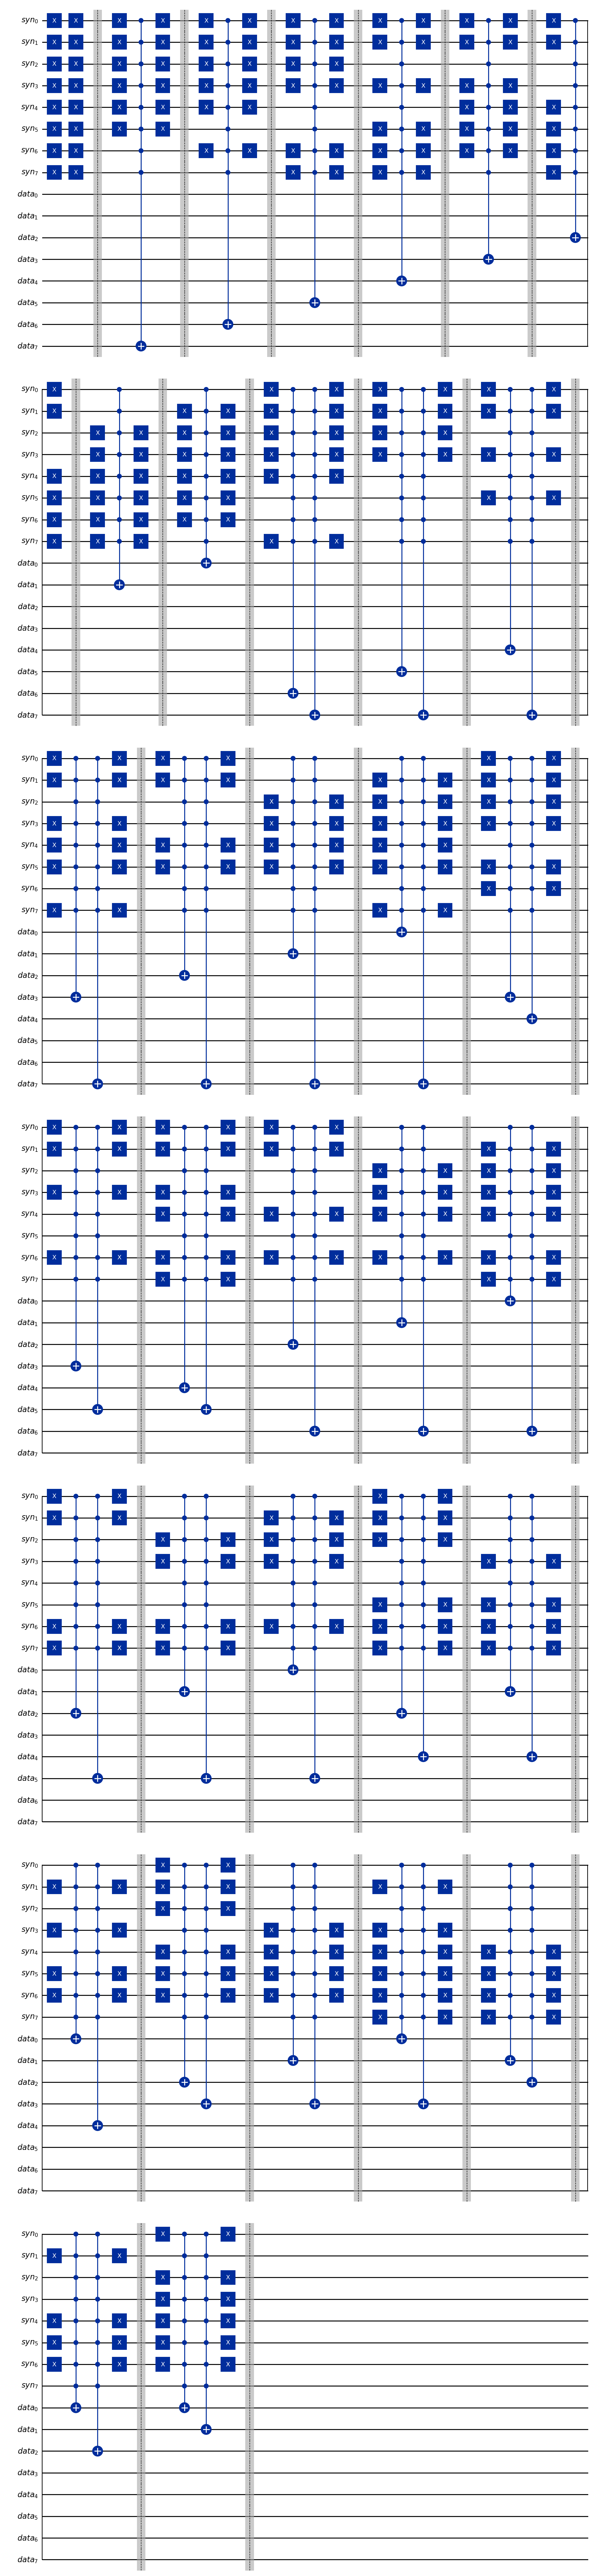

In [836]:
gate.draw('mpl')

In [837]:
m

8

In [838]:
n

8

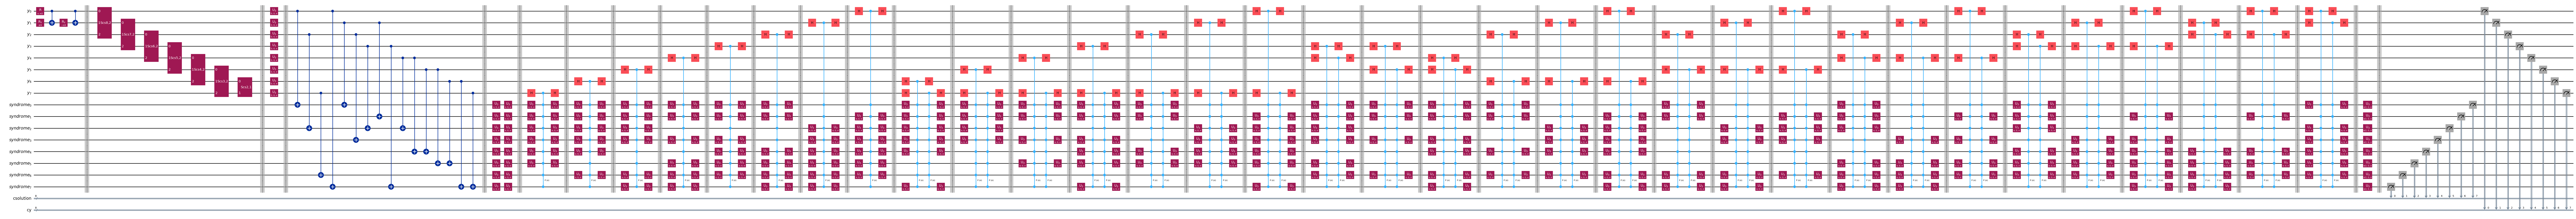

In [839]:
dqi_lookuptable = dqi_circuit_wo_decoder.copy()
dqi_lookuptable.barrier()

dqi_lookuptable.append(gate, list(range(m, m+n)) + list(range(m)))

for i in range(syndrome_qregs.size):
    dqi_lookuptable.h(dicke_qregs.size+i)
dqi_lookuptable.barrier()
dqi_lookuptable.measure(dicke_qregs, dicke_cregs)
dqi_lookuptable.measure(syndrome_qregs, syndrome_cregs[::-1])
dqi_lookuptable.decompose().decompose().draw('mpl', fold=-1)

In [840]:
from qiskit_aer import AerSimulator
from qiskit import transpile

simulator = AerSimulator()
transpiled_circuit = transpile(dqi_lookuptable, backend=simulator)
result = simulator.run(transpiled_circuit, shots=100000).result()
counts = result.get_counts(dqi_lookuptable)
{k: v for k, v in sorted(counts.items(), key=lambda item: item[1], reverse=True)}

{'00000000 01011001': 11225,
 '00000000 10100110': 10978,
 '00000000 01001001': 3506,
 '00000000 01011011': 3463,
 '00000000 10110110': 3457,
 '00000000 11100110': 3452,
 '00000000 10011001': 3397,
 '00000000 10100100': 3393,
 '00000000 00011001': 3346,
 '00000000 01100110': 3345,
 '00000000 10100010': 1163,
 '00000000 10011110': 1107,
 '00000000 01101001': 1099,
 '00000000 10010110': 1094,
 '00000000 01010001': 1079,
 '00000000 01011101': 1077,
 '00000000 01010101': 1075,
 '00000000 01100101': 1067,
 '00000000 10101010': 1066,
 '00000000 10101110': 1062,
 '00000000 10011010': 1061,
 '00000000 01100001': 1028,
 '00000000 00000000': 708,
 '00000000 11111111': 701,
 '00000000 01101111': 561,
 '00000000 10010000': 557,
 '00000000 10101101': 556,
 '00000000 11010010': 549,
 '00000000 10001001': 548,
 '00000000 01010010': 547,
 '00000000 01111101': 543,
 '00000000 11100100': 542,
 '00000000 10000010': 527,
 '00000000 00100110': 523,
 '00000000 10011011': 521,
 '00000000 00101101': 517,
 '00

In [841]:
brute_force_results = brute_force_max(B, v, first_part="0"*m)
external_data = counts  # A dict of {binary_label: count}
plot_results_union_plotly(
    brute_force_results, 
    external_data, 
    plot_name="Comparison of DQI result and True Objective Values", 
    spline_smoothing=0.8
)


In [842]:
external_data = {k: v  for k, v in sorted(counts.items(), key=lambda item: item[1], reverse=True) if sum([int(v) for v in k.split(" ")[0]]) == 0}
brute_force_results = brute_force_max(B, v, first_part="0"*m)
plot_results_union_plotly(
    brute_force_results, 
    external_data, 
    plot_name="Comparison of DQI result and True Objective Values (Filtered)", 
    spline_smoothing=1.3
)

In [843]:
combined_counts = combine_counts(counts)
brute_force_results = brute_force_max(B, v, first_part="")
plot_results_union_plotly(
    brute_force_results, 
    combined_counts, 
    plot_name="Comparison of DQI result and True Objective Values (Combined)", 
    spline_smoothing=1.3
)